# Logistic Regression
Logistic Regression is a method for analyzing a dataset in which there are one or more independent variables that determine an outcome. It is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). 

If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), or else it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a *binary classifier*.

Just like a Linear Regression model, a Logistic Regression model computes a
weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the *logistic* of this result,
### P = hθ(x)= σ(θT·X)
The logistic — also called the *logit*, noted σ(·) — is a *sigmoid function* (i.e., S-shaped) that outputs a number between 0 and 1,
![Logit](https://wikimedia.org/api/rest_v1/media/math/render/svg/5e648e1dd38ef843d57777cd34c67465bbca694f)

In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [448]:
train = pd.read_csv('titanic_train.csv')

#### Data Dictionary
Variable|Definition
------------ | -------------
Survived|Survival	
Pclass|Ticket class
Sex|Sex	
Age|Age in years	
SibSp|# of siblings / spouses aboard the Titanic	
Parch|# of parents / children aboard the Titanic	
Ticket|Ticket number	
Fare|Passenger fare	
Cabin|Cabin number	
Embarked|Port of Embarkation {C = Cherbourg, Q = Queenstown, S = Southampton}

In [449]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploring the data

#### Lets see what we are missing
We will create a heatmap plot of the True/False values that we get from doing a `isnull()` check on the dataset.

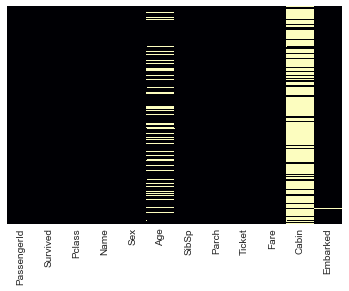

In [450]:
sns.heatmap(train.isnull(),cbar=False, cmap='magma',yticklabels=False)

_So, we are missing a lot of age data and most of cabin data._

#### Now, lets find out if chances of survival had anything to do with gender. 

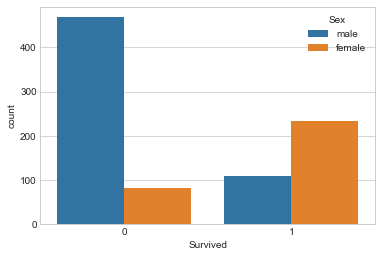

In [451]:
sns.countplot(x='Survived',data=train,hue='Sex')

_So, females survived 2 times more than males. And the number of males who didn't survive is 5 times more than females who didn't._

#### Lets find out if people in different classes had different survival rates or not.

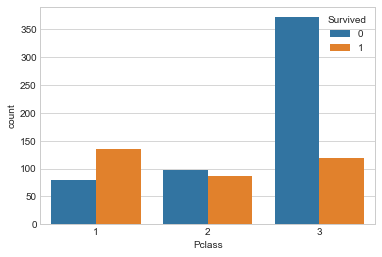

In [452]:
sns.countplot(x='Pclass',data=train,hue='Survived')

_So, survival rate among people in first class is much greater than 2nd class. And majority of the passengers in the third class did not survive_

#### Lets find out the different age groups in the ship

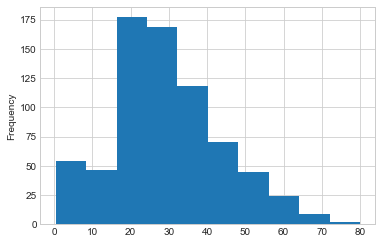

In [453]:
train['Age'].plot.hist()

_So, people in the ship were mostly in their twenties and thirties. _

## Data Cleaning

We have to fill in the missing age data with something meaningful in the age column.
We can find out what is median age of different classes and then fill that data in the entries with the missing values.

In [454]:
train[train['Pclass']==1]['Age'].median()

37.0

In [455]:
train[train['Pclass']==2]['Age'].median()

29.0

In [456]:
train[train['Pclass']==3]['Age'].median()

24.0

In [457]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [458]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

***Lets check the heatmap again***

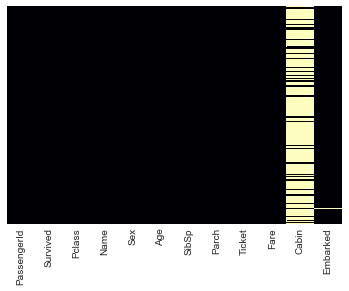

In [459]:
sns.heatmap(train.isnull(),cbar=False, cmap='magma',yticklabels=False)

Now we have eliminated the null values in the Age column.

**But as there are just too many missing values in the cabin column we'd be better off without it**

In [460]:
train.drop('Cabin',axis=1,inplace=True)

**In the Embarked column there only a few missing values so we can go ahead and drop those rows that contain them.**

In [461]:
train.dropna(inplace=True)

_Now if we generate that heatmap again we should see one color only, which would indicate that there are no longer any missing values in the dataset._

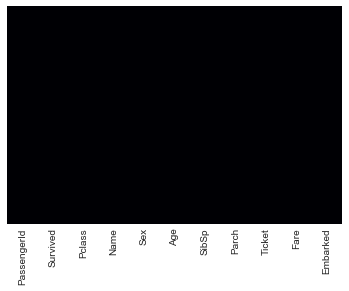

In [462]:
sns.heatmap(train.isnull(),cbar=False, cmap='magma',yticklabels=False)

## Converting Categorical Features 

In order to make the Categorical columns understandable to the Machine Learning algorithm, we are going to convert them into "_dummy variables_".
- N.B: We have to avoid ***multi-colinearity***, which is when one column is a perfect predictor of another column.

In [463]:
sex=pd.get_dummies(train['Sex'],drop_first=True)

In [464]:
embarked=pd.get_dummies(train['Embarked'],drop_first=True)

Now, we add these columns to our dataframe

In [465]:
train=pd.concat([train, sex, embarked],axis=1)
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0


Now we drop some columns that can't use

In [466]:
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)

In [467]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Cleaning the test data

## Building the Model

Our features and lables

In [468]:
X = train.drop('Survived',axis=1)
y = train['Survived']

importing the train_test_splt

In [469]:
from sklearn.model_selection import train_test_split

In [470]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Importing the model

In [471]:
from sklearn.linear_model import LogisticRegression

Creating an instance of the model

In [472]:
logm=LogisticRegression()

Training the model with our train set

In [473]:
logm.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Making predictions

In [474]:
pred=logm.predict(X_test)

Evaluating

In [475]:
from sklearn.metrics import classification_report

In [476]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.80      0.91      0.85       163
          1       0.82      0.65      0.73       104

avg / total       0.81      0.81      0.80       267



In [477]:
from sklearn.metrics import confusion_matrix

In [478]:
confusion_matrix(y_test,pred)

array([[148,  15],
       [ 36,  68]], dtype=int64)

### Working with the titanic_test dataset

In [479]:
test = pd.read_csv('titanic_test.csv')

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 27
    else:
        return Age

test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)

test.drop('Cabin',axis=1,inplace=True)

test.dropna(inplace=True)

sex=pd.get_dummies(test['Sex'],drop_first=True)

embarked=pd.get_dummies(test['Embarked'],drop_first=True)

test=pd.concat([test, sex, embarked],axis=1)

test.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)

test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3,34.5,0,0,7.8292,1,1,0
1,3,47.0,1,0,7.0000,0,0,1
2,2,62.0,0,0,9.6875,1,1,0
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,0,0,1


In [480]:
logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)
pred=logm.predict(test)
pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0,

In [481]:
test=pd.concat([test, pd.DataFrame(pred)],axis=1)
test.rename(columns={0:'Survival'},inplace=True)

In [482]:
test.head(10)

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survival
0,3.0,34.5,0.0,0.0,7.8292,1.0,1.0,0.0,0.0
1,3.0,47.0,1.0,0.0,7.0000,0.0,0.0,1.0,0.0
2,2.0,62.0,0.0,0.0,9.6875,1.0,1.0,0.0,0.0
3,3.0,27.0,0.0,0.0,8.6625,1.0,0.0,1.0,0.0
4,3.0,22.0,1.0,1.0,12.2875,0.0,0.0,1.0,1.0
5,3.0,14.0,0.0,0.0,9.2250,1.0,0.0,1.0,0.0
6,3.0,30.0,0.0,0.0,7.6292,0.0,1.0,0.0,1.0
7,2.0,26.0,1.0,1.0,29.0000,1.0,0.0,1.0,0.0
8,3.0,18.0,0.0,0.0,7.2292,0.0,0.0,0.0,1.0
9,3.0,21.0,2.0,0.0,24.1500,1.0,0.0,1.0,0.0
